In [115]:
from matplotlib.pyplot import rc, rcParams, grid 
import matplotlib.patches as mpatches

import urllib.request
import requests
import bs4
from datetime import date, time
from math import *
import numpy as np
import pandas as pd
# import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline
plt.style.use('seaborn-poster')
sns.set_theme(context='talk', style='darkgrid')  # poster notebook

In [116]:
def read_yuma(almanac_file):
    ''' 
    Reading and parsing YUMA asci format
    INPUT:
        Almanac: YUMA format 
    OUTPUT:
        almanac_data -  type list of list [strings value], number of lists is equal to number of satellite
                        one list contain satellites according to the order:         
                        ['SV ID', 'Health', 'Eccentricity', 'Time of Applicability(s)', 'Inclination(rad)', 
                        'Rate of Right Ascen(r/s)', 'SQRT(A)  (m 1/2)', 'Right Ascen at Week(rad)', 
                        'Argument of Perigee(rad)', 'Mean Anom(rad)', 'Af0(s)', 'Af1(s/s)', 'Week no']
        
    '''
    
    if almanac_file:
        alm = open(almanac_file)
        
        alm_lines = alm.readlines()
        all_sat = []
        for idx, value in enumerate(alm_lines):
            # print(idx, value)
            
            if value[0:3]=='ID:':
                one_sat_block = alm_lines[idx:idx+13]
                one_sat = []
                for line in one_sat_block:
                    data = line.split(':')
                    one_sat.append(float(data[1].strip()))
                all_sat.append(one_sat)
        alm.close()
        all_sat = np.array(all_sat)
        return (all_sat)  

In [117]:
def date2tow(data):
    """
    Parameters
    data : data -- list [year,month,day,hour,minute,second]
    Returns
    week : GPS week, for the second rollover, in range 0-1023
    tow : second of week.
    """
    # difference of days
    dd = date.toordinal(date(data[0], data[1], data[2])) - date.toordinal(date(2019, 4, 7))    
    # week number
    week = dd // 7
    #day of week
    dow = dd % 7
    # time of week
    tow = dow * 86400 + data[3] * 3600 + data[4] * 60 + data[5]
    return week, tow

In [118]:
def satpos(nav, week, tow):
    """jedna duża funkcja, algorytm na TEAMS, zwracać ma x, y, z"""
    # stałe
    mi = 3.986005e14  # prędkość kątowa obrotu Ziemii - to, czy omge?
    omge = 7.2921151467e-5

    prn = nav[0]
    e = nav[2]
    toa = nav[3]
    i = nav[4]
    Omega_dot = nav[5]
    sqrta = nav[6]
    Omega = nav[7]
    omega = nav[8]
    M0 = nav[9]
    gps_week = nav[12] 

    t = week * 7 * 86400 + tow
    toa_weeks = gps_week * 7 * 86400 + toa

    # tk = tow - toa
    tk = t - toa_weeks
    # print(tk)  # print(tk/86400)

    # Krok 2 algorytmu
    a = sqrta**2
    n = np.sqrt(mi/(a**3))
    Mk = M0 + n * tk
    # Ek = Mk + e * np.sin(EK)  # rozwiazanie iteracyjne
    Epop = Mk
    while True:
        E = Mk + e * np.sin(Epop)
        # print(E)
        if (abs(E-Epop)<10**(-12)):
            break
        Epop = E
    Ek = E
    # atan2 z math lub arctan2 z numpy
    vk = np.arctan2(np.sqrt(1 - e**2)*np.sin(Ek) , np.cos(Ek)-e)
    Fik = vk + omega
    rk = a * (1 - e * np.cos(Ek))
    xk = rk * np.cos(Fik)
    yk = rk * np.sin(Fik)
    # na dole toa czy toa_weeks?
    Omega_k = Omega + (Omega_dot - omge) * tk - omge * toa  # skąd omega_E?
    Xk = xk * np.cos(Omega_k) - yk * np.cos(i) * np.sin(Omega_k)
    Yk = xk * np.sin(Omega_k) + yk * np.cos(i) * np.cos(Omega_k)
    Zk = yk * np.sin(i)
    return np.array([Xk, Yk, Zk])

In [119]:
def geo2xyz(fi, lam, h, a=6378137, e2=0.00669437999013):
    """funkcja zamienia współrzędne geodezyjne na kartezjańskie fi, lam podajemy w radianach do wzorów, do fcji w deg"""
    fi = np.deg2rad(fi)
    lam = np.deg2rad(lam)
    N = a / np.sqrt(1 - e2 * np.sin(fi) ** 2)
    x = (N + h) * np.cos(fi) * np.cos(lam)
    y = (N + h) * np.cos(fi) * np.sin(lam)
    z = (N * (1 - e2) + h) * np.sin(fi)
    return np.array([x, y, z])

In [120]:
def xyz2neu(fi, lam, A, B):
    # def xyz2neu(A:punktodniesienia/startowy, B:koniecwektora):
    """funkcja zamienia wsp kartezjańskie na topocentryczne neu
    A, B reprezentują punkty, A to początek, B to koniec wektora
    A, B są typu np.array i mają 3 współrzędne: x, y, z
    fi, lam to współrzędne punktu A potrzebne do macierzy obrotu"""
    # x, y, z -> north, east, up
    # fi, lambda, lotniska
    # wektor AB
    fi = np.deg2rad(fi)
    lam = np.deg2rad(lam)
    rotation_matrix = np.array([
        [-1*np.sin(fi)*np.cos(lam), -1*np.sin(lam), np.cos(fi)*np.cos(lam)],
        [-1*np.sin(fi)*np.sin(lam), np.cos(lam), np.cos(fi)*np.sin(lam)],
        [np.cos(fi), 0, np.sin(fi)]
    ])
    vector = B - A
    return rotation_matrix.transpose() @ vector

In [121]:
def Hirvonen(x, y, z, a=6378137, e2=0.00669437999013):
    """zwraca współrzędne fi, lambda, h. Algorytm Hirvonena"""
    #     epsilon = 0.00005/3600  # epsilon w stopniach dziesiętnych
    # Krasowski - a=6378245, e2=0.0066934215520398155
    # GRS80 - a=6378137, e2=0.00669437999013
    r = sqrt(x**2 + y**2)
    phi_old = atan((z / r) * (1 - e2)**(-1))
    while True:
        N = a / (sqrt(1 - e2 * (sin(phi_old))**2))
        h = (r / cos(phi_old)) - N
        phi_new = atan((z / r) * (1 - e2 * (N / (N + h)))**(-1) )
        if abs(phi_new - phi_old) < radians(0.00005 / 3600):
            break
        else:
            phi_old = phi_new
#     lam = atan(y / x)
    lam = np.arctan2(y, x)
    N = a / (sqrt(1 - e2 * (sin(phi_new))**2))
    h = (r / cos(phi_new)) - N
    return degrees(phi_new), degrees(lam), h

In [122]:
def plot_skyplot(sat_positions):
    # sat_positions - [PRN, el, az] w stopniach
    rc('grid', color='gray', linewidth=1, linestyle='--')
    fontsize = 20
    rc('xtick', labelsize = fontsize)
    rc('ytick', labelsize = fontsize)
    rc('font', size = fontsize)
    # define colors
    
    green   ='#467821'
    blue    ='#348ABD'
    red     ='#A60628'
    orange  ='#E24A33'
    purple  ='#7A68A6'

        # start ploting
    fig =plt.figure(figsize=(18,18))
    plt.subplots_adjust(bottom= 0.1, 
                        top   = 0.85,
                        left  = 0.1, 
                        right = 0.74)
    ax = fig.add_subplot(polar=True) #define a polar type of coordinates
    ax.set_theta_zero_location('N') # ustawienie kierunku północy na górze wykresu
    ax.set_theta_direction(-1) # ustawienie kierunku przyrostu azymutu w prawo
    
    PG = 0 # zliczanie satelitów GPS
    
    for (PRN, el, az) in sat_positions: 
        PG += 1
        ### show sat number

        ax.annotate(PRN, 
                    xy=(np.radians(az), 90-el),
                    bbox=dict(boxstyle="round4, pad=0.3, rounding_size=-0.2", fc='blue', alpha=0.75),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color = 'white')
        #                     # 

    gps     = mpatches.Patch(color='blue',  label='{:2.0f}  widocznych satelitów'.format(PG))
    plt.legend(handles=[gps], loc='upper right', borderaxespad=0.)

    # axis ticks descriptions    
    ax.set_yticks(range(0, 90+10, 10))                   # Define the yticks
    yLabel = ['90', '', '', '60', '', '', '30', '', '', '']
    ax.set_yticklabels(yLabel)
    # saving and showing plot
    # plt.savefig('satellite_skyplot.pdf')
    ax.set_title('Skyplot. +'+str(GODZINA)+'h od wybranej daty.' + ' (maska: '+str(MASKA)+')', loc='center', fontsize=36)
    plt.show() # wyświetleni

# ⚙️ parametry do ustawienia

In [123]:
DATA = [2022, 2, 25, 0, 0, 0]  # data obserwacji
FI_, LAM_, H_ = 52, 21, 100  # współrzędne miejsca obserwacji
MASKA = 10  # elewacja w stopniach

# Pobieranie najbliższego wybranej dacie poprzedniego almanachu

In [124]:
r = requests.get('https://celestrak.com/GPS/almanac/Yuma/' + str(DATA[0]))
soup = bs4.BeautifulSoup(r.text, 'html.parser')
# divv = soup.find_all(attrs={"style": "overflow-x: auto; "})
div = soup.find(style="overflow-x: auto; ")
linki = div.find_all('a')
# linki   # linki[0]['href'] linki[0].string linki[0].text
w, t = date2tow(DATA)
lista = []
for item in linki:
    lista.append(float(item.text))
number = float(str(w)+'.'+str(t))
previous = min([k for k in lista if k<=number], key=lambda x: number-x)
prev_text = f"{previous:.6f}".zfill(11)

# format linku: https://celestrak.com/GPS/almanac/Yuma/2021/almanac.yuma.week0105.233472.txt
url_closest = 'https://celestrak.com/GPS/almanac/Yuma/' + str(DATA[0]) + '/almanac.yuma.week' + prev_text + '.txt'
urllib.request.urlretrieve(url_closest, 'closest_almanac.txt');

In [125]:
# Pobieranie aktualnego almanachu
url_current = 'https://www.navcen.uscg.gov/?pageName=currentAlmanac&format=yuma'
almanac_name = 'current_almanac.txt'
urllib.request.urlretrieve(url_current, almanac_name);

# ⚙️ wybór pliku almanachu
do wyboru: 

- default_almanac.txt
- current_almanac.txt
- closest_almanac.txt

In [126]:
PLIK = 'default_almanac.txt'  # ścieżka do pliku z danymi z almanachu, oczywiście można też wgrać swój 

# Obliczenia i wykresy

In [127]:
navall = read_yuma(PLIK)
datak = list(DATA[:])
odbiornik = geo2xyz(FI_, LAM_, H_)

# dict24 = dict(DOP=dict(), test=['test0', 'test1'], widoczne=[])
DOP = dict(GDOP=[], PDOP=[], TDOP=[], HDOP=[], VDOP=[])
ile_widocznych = []
jakie_widoczne = dict()
satelity_neu = dict()
satelity_xyz = dict()
satelity_xyz2 = dict()
satelity_elaz = []
satelity_elazd = dict()
better_elaz = dict()
elewacje = dict()
elewacje2 = dict()

for i in range(1,25):
    week, tow = date2tow(datak)  ############
    df = pd.DataFrame(navall, columns=['PRN', 'health', 'eccentricity', 'toa', 'oi', 'rora', 'sqrta', 'raaw', 'aop', 'ma', 'af0', 'af1', 'week'])
    xsat = []
    ysat = []
    zsat = []
    xodb = []
    yodb = []
    zodb = []
    nn = []
    ee = []
    uu = []
    az = []
    el = []
    for sat in navall:
        Xs = satpos(sat, week, tow)
        xsat.append(Xs[0])
        ysat.append(Xs[1])
        zsat.append(Xs[2])
        Xr = odbiornik
        xodb.append(Xr[0])
        yodb.append(Xr[1])
        zodb.append(Xr[2])
        # Xsr = Xs - Xr
        neu = xyz2neu(FI_, LAM_, Xr, Xs)
        n, e, u = neu
        nn.append(n)
        ee.append(e)
        uu.append(u)
        Az = np.arctan2(e,n)  # azymut
        ele = np.arcsin(u/np.sqrt(n**2 + e**2 + u**2))  # elewacja
        azst = np.rad2deg(Az)
        elst = np.rad2deg(ele)
        az.append(azst)
        el.append(elst)
    df['xsat'] = xsat
    df['ysat'] = ysat
    df['zsat'] = zsat
    df['xodb'] = xodb
    df['yodb'] = yodb
    df['zodb'] = zodb
    df['n'] = nn
    df['e'] = ee
    df['u'] = uu
    df['az'] = az
    df['el'] = el
    
    df.set_index('PRN', inplace=True)
    df['distance'] = df.apply(lambda row : np.linalg.norm(np.array([row['xsat'], row['ysat'], row['zsat']]) - np.array([row['xodb'], row['yodb'], row['zodb']])), axis=1)
    df['Ax'] = df.apply(lambda row : -(row['xsat'] - row['xodb'])/row['distance'], axis=1)
    df['Ay'] = df.apply(lambda row : -(row['ysat'] - row['yodb'])/row['distance'], axis=1)
    df['Az'] = df.apply(lambda row : -(row['zsat'] - row['zodb'])/row['distance'], axis=1)
    
    maska_df = df[df['el'] > MASKA]
    A = maska_df[['Ax', 'Ay', 'Az']].to_numpy()
    wiersze = maska_df.shape[0]
    ile_widocznych.append(wiersze)  ###
    jakie_widoczne[i-1] = maska_df.index.values ###
    for index, row in maska_df.iterrows():
        lista = [row.n, row.e, row.u]
        try:
            satelity_neu[index].append(lista)
        except KeyError:
            satelity_neu[index] = [lista]
        temp = [row.xsat, row.ysat, row.zsat]
        try:
            satelity_xyz[index].append(temp)
        except KeyError:
            satelity_xyz[index] = [temp]
        other = [row.el, row.az]
        try:
            better_elaz[index].append(other)
        except KeyError:
            better_elaz[index] = [other]
        satelity_elaz.append([index, row.el, row.az])
        
        try:
            elewacje[index]['h'].append(i-1)
            elewacje[index]['el'].append(row.el)
        except KeyError:
            elewacje[index] = dict(h=[i-1], el=[row.el])
            
        try:
            satelity_elazd[i-1].append(i-1)
        except KeyError:
            satelity_elazd
    for index, row in df.iterrows():
        #  elewacje 24h
        try:
            elewacje2[index]['h'].append(i-1)
            elewacje2[index]['el'].append(row.el)
        except KeyError:
            elewacje2[index] = dict(h=[i-1], el=[row.el])
        #  groundtrack 24h
        temp = [row.xsat, row.ysat, row.zsat]
        try:
            satelity_xyz2[index].append(temp)
        except KeyError:
            satelity_xyz2[index] = [temp]
        
    ones = np.array([np.repeat(1, wiersze)])
    A = np.concatenate((A, ones.T), axis=1)
    Q = np.linalg.inv(A.T @ A)
    qx, qy, qz, qt = np.diagonal(Q)
    GDOP = np.sqrt(qx+qy+qz+qt)
    PDOP = np.sqrt(qx+qy+qz)
    TDOP = np.sqrt(qt)
    fi = np.deg2rad(FI_)
    lam = np.deg2rad(LAM_)
    R = np.array([
        [-np.sin(fi)*np.cos(lam), -np.sin(lam), np.cos(fi)*np.cos(lam)],
        [-np.sin(fi)*np.sin(lam), np.cos(lam), np.cos(fi)*np.sin(lam)],
        [np.cos(fi), 0, np.sin(fi)]])
    Qxyz = Q[:-1,:-1]
    Qneu = R.T @ Qxyz @ R
    qn, qe, qu = np.diagonal(Qneu)
    HDOP = np.sqrt(qn+qe)
    VDOP = np.sqrt(qu)
    DOP['GDOP'].append(GDOP)  ###
    DOP['PDOP'].append(PDOP)  ###
    DOP['TDOP'].append(TDOP)  ###
    DOP['HDOP'].append(HDOP)  ###
    DOP['VDOP'].append(VDOP)  ###
    
    
    datak[3] = i ############
#     print(datak) ############

## Elewacje

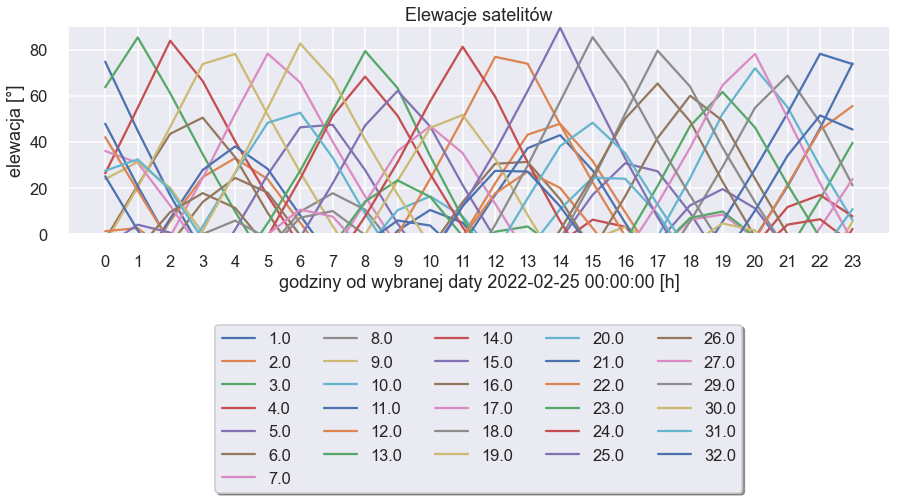

In [128]:
sns.set_theme(context='talk', style='darkgrid')  # style=ticks white 
for k, v in elewacje2.items():
    plt.plot(v['h'], v['el'], label=k)
    
plt.title('Elewacje satelitów')
plt.ylabel('elewacja [°]')
plt.xlabel('godziny od wybranej daty ' + str(date(*DATA[0:3])) + ' ' + str(time(*DATA[3:])) + ' [h]')
plt.xticks(np.arange(0,24))
ax = plt.gca()
ax.set_ylim([0, 90])
# Legenda do wywalenia raczej
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.40),
          fancybox=True, shadow=True, ncol=5)
plt.tight_layout()
plt.show()

In [129]:
numeryy = []
godzinyy = []
elewacjee = []
for prn, v in elewacje2.items():
    godzinyy.extend(v['h'])
    elewacjee.extend(v['el'])
    for i in range(len(v['h'])):
        numeryy.append(prn)
eledf = pd.DataFrame(list(zip(numeryy, godzinyy, elewacjee)), columns=['PRN', 'h', 'el'])

In [130]:
fig = px.line(eledf, x='h', y='el', color='PRN',title='Liczba widocznych satelitów powyżej maski: '+str(MASKA)+' stopni', labels={'h':'godziny od wybranej daty ' + str(date(*DATA[0:3])) + ' ' + str(time(*DATA[3:])) + ' [h]','el':'elewacja [°]'}, template='plotly_dark')
fig.update_layout(hovermode="closest", xaxis = dict(tickmode = 'linear', tick0=0, dtick=1))
fig.update_xaxes(showspikes=True)
fig.update(layout_yaxis_range = [MASKA, 90])
# fig.update_yaxes(showspikes=True)
fig.show()

In [131]:
fig = px.line(eledf, x='h', y='el', color='PRN',title='Elewacje satelitów', labels={'h':'godziny od wybranej daty ' + str(date(*DATA[0:3])) + ' ' + str(time(*DATA[3:])) + ' [h]','el':'elewacja [°]'}, template='plotly_dark')
fig.update_layout(hovermode="closest", xaxis = dict(tickmode = 'linear', tick0=0, dtick=1))
fig.update_xaxes(showspikes=True)
fig.show()

## Liczba widocznych satelitów

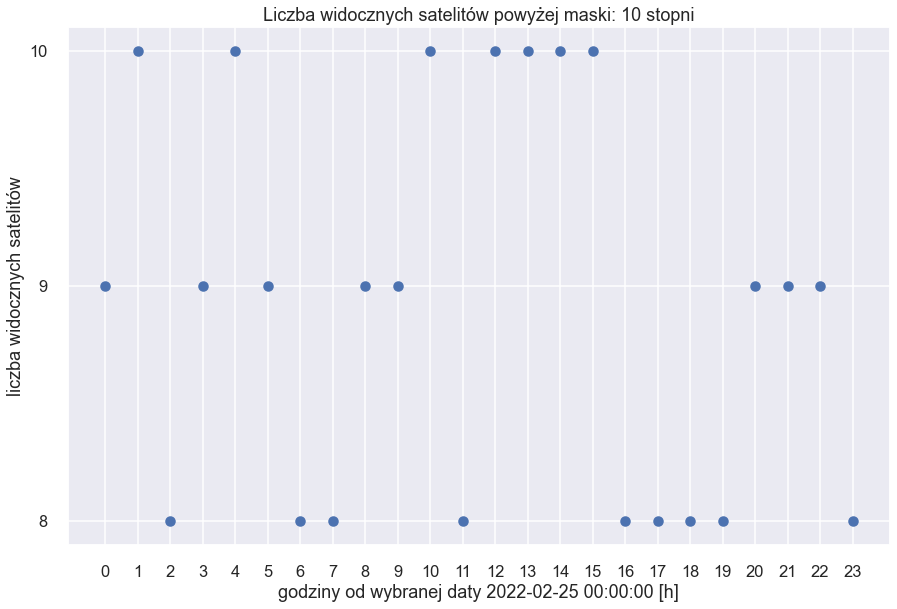

In [132]:
plt.scatter(range(0,24),ile_widocznych)   
plt.title('Liczba widocznych satelitów powyżej maski: '+str(MASKA)+' stopni')
plt.ylabel('liczba widocznych satelitów')
plt.xlabel('godziny od wybranej daty ' + str(date(*DATA[0:3])) + ' ' + str(time(*DATA[3:])) + ' [h]')
plt.xticks(np.arange(0,24))
plt.yticks(np.arange(min(ile_widocznych),max(ile_widocznych)+1))
plt.tight_layout()
plt.show()

In [133]:
iledf = pd.DataFrame(list(zip(ile_widocznych, godzinyy)), columns=['ile', 'h'])
# iledf

In [134]:
fig = px.scatter(iledf, x='h', y='ile', title='Liczba widocznych satelitów powyżej maski: '+str(MASKA)+' stopni', labels={'h':'godziny od wybranej daty ' + str(date(*DATA[0:3])) + ' ' + str(time(*DATA[3:])) + ' [h]','ile':'liczba widocznych satelitów'}, template='plotly_dark')
fig.update_traces(marker=dict(color='blue',opacity=1,size=14,
                              line=dict(width=2,
                                        color='lightblue')))
fig.update_layout(hovermode="closest", xaxis = dict(tickmode = 'linear', tick0=0, dtick=1),
                 yaxis=dict(tickmode='linear', tick0=min(ile_widocznych), dtick=1))

fig.show()

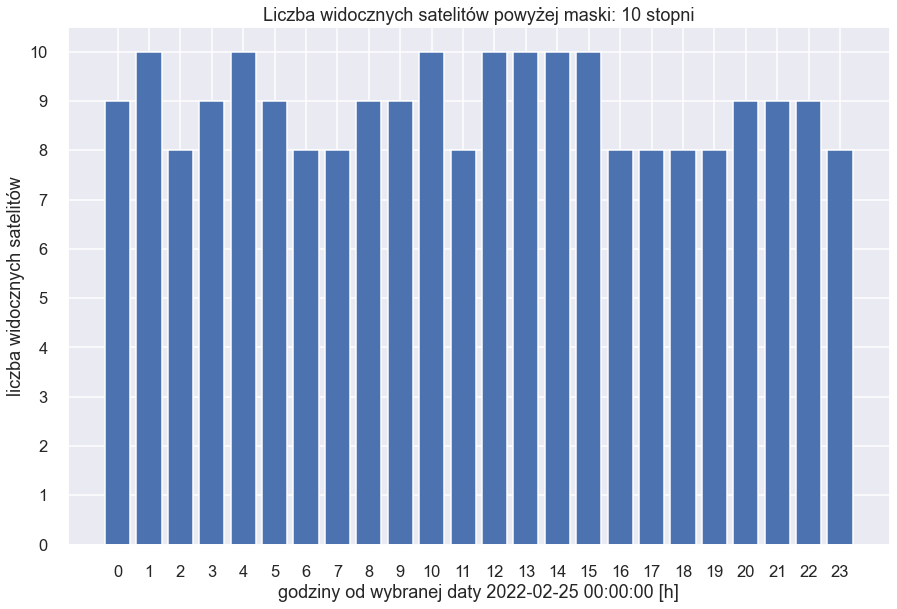

In [135]:
plt.bar(range(0,24),ile_widocznych)
plt.title('Liczba widocznych satelitów powyżej maski: '+str(MASKA)+' stopni')
plt.ylabel('liczba widocznych satelitów')
plt.xlabel('godziny od wybranej daty ' + str(date(*DATA[0:3])) + ' ' + str(time(*DATA[3:])) + ' [h]')
plt.xticks(np.arange(0,24))
plt.yticks(np.arange(0,max(ile_widocznych)+1))
plt.tight_layout()
plt.show()

In [136]:
fig = px.bar(iledf, x='h', y='ile', text='ile',title='Liczba widocznych satelitów powyżej maski: '+str(MASKA)+' stopni', 
            labels={'h':'godziny od wybranej daty ' + str(date(*DATA[0:3])) + ' ' + str(time(*DATA[3:])) + ' [h]','ile':'liczba widocznych satelitów'})
fig.update_layout(hovermode="closest", xaxis = dict(tickmode = 'linear', tick0=0, dtick=1), 
                  yaxis = dict(tickmode = 'linear', tick0=0, dtick=1))
fig.show()

## Współczynniki DOP

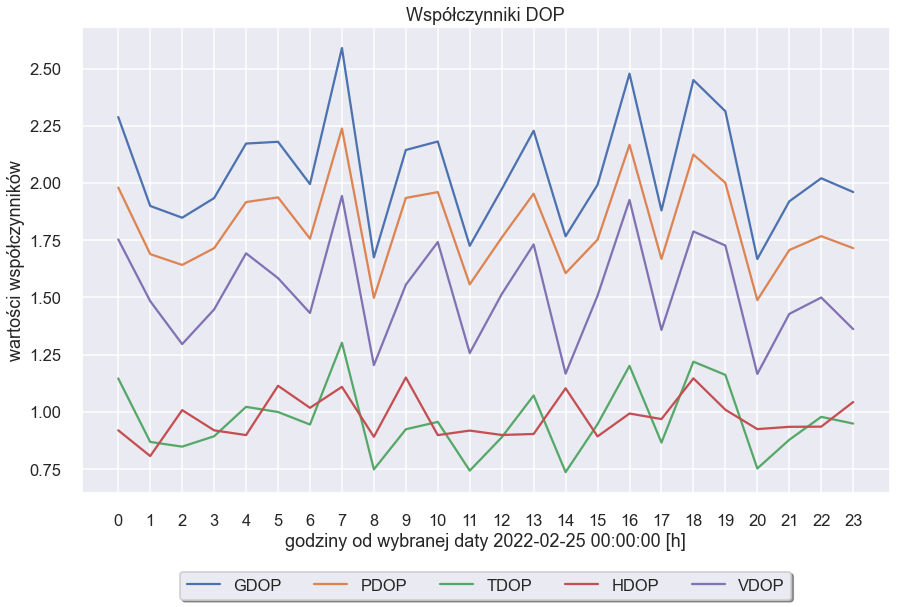

In [137]:
for k, v in DOP.items():
    plt.plot(range(0,24), v, label=k)
    
plt.title('Współczynniki DOP')
plt.ylabel('wartości współczynników')
plt.xlabel('godziny od wybranej daty ' + str(date(*DATA[0:3])) + ' ' + str(time(*DATA[3:])) + ' [h]')
plt.xticks(np.arange(0,24))
ax = plt.gca()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5)
plt.tight_layout()
plt.show()

In [138]:
dopdf = pd.DataFrame(list(zip(godzinyy, DOP['GDOP'], DOP['PDOP'], DOP['TDOP'], DOP['HDOP'], DOP['VDOP'])), columns=['h', 'GDOP', 'PDOP', 'TDOP', 'HDOP', 'VDOP'])

In [139]:
fig = px.line(dopdf, x='h', y=['GDOP', 'PDOP', 'TDOP', 'HDOP', 'VDOP'], title='Współczynniki DOP', labels={'h':'godziny od wybranej daty ' + str(date(*DATA[0:3])) + ' ' + str(time(*DATA[3:])) + ' [h]'}, template='plotly_dark')
fig.update_layout(hovermode="closest", xaxis = dict(tickmode = 'linear', tick0=0, dtick=1))
fig.show()

## Wyszczególnienie widocznych satelitów

In [140]:
godzinyyy = []
numeryyy = []
useless = []
for k, v in jakie_widoczne.items():
    for i in range(len(v)):
        godzinyyy.append(k)
        useless.append(1)
    numeryyy.extend(v)

In [141]:
jakiedf = pd.DataFrame(list(zip(godzinyyy, numeryyy, useless)), columns=['h', 'PRN', 'widoczne'])

In [142]:
jakiedf["PRN"] = jakiedf["PRN"].astype(str)
fig = px.bar(jakiedf, x="h", y="widoczne", color="PRN", title="Wyszczególnienie widocznych satelitów", labels={'widoczne':'liczba widocznych satelitów','h':'godziny od wybranej daty ' + str(date(*DATA[0:3])) + ' ' + str(time(*DATA[3:])) + ' [h]'}, template='plotly_dark')
fig.update_layout(hovermode="closest", xaxis = dict(tickmode = 'linear', tick0=0, dtick=1), 
                  yaxis = dict(tickmode = 'linear', tick0=0, dtick=1))
fig.show()

## Skyplot

### ⚙️ wybór satelity

In [143]:
NUMER = 1.0  # numer PRN satelity, dla którego będzie rysowany skyplot

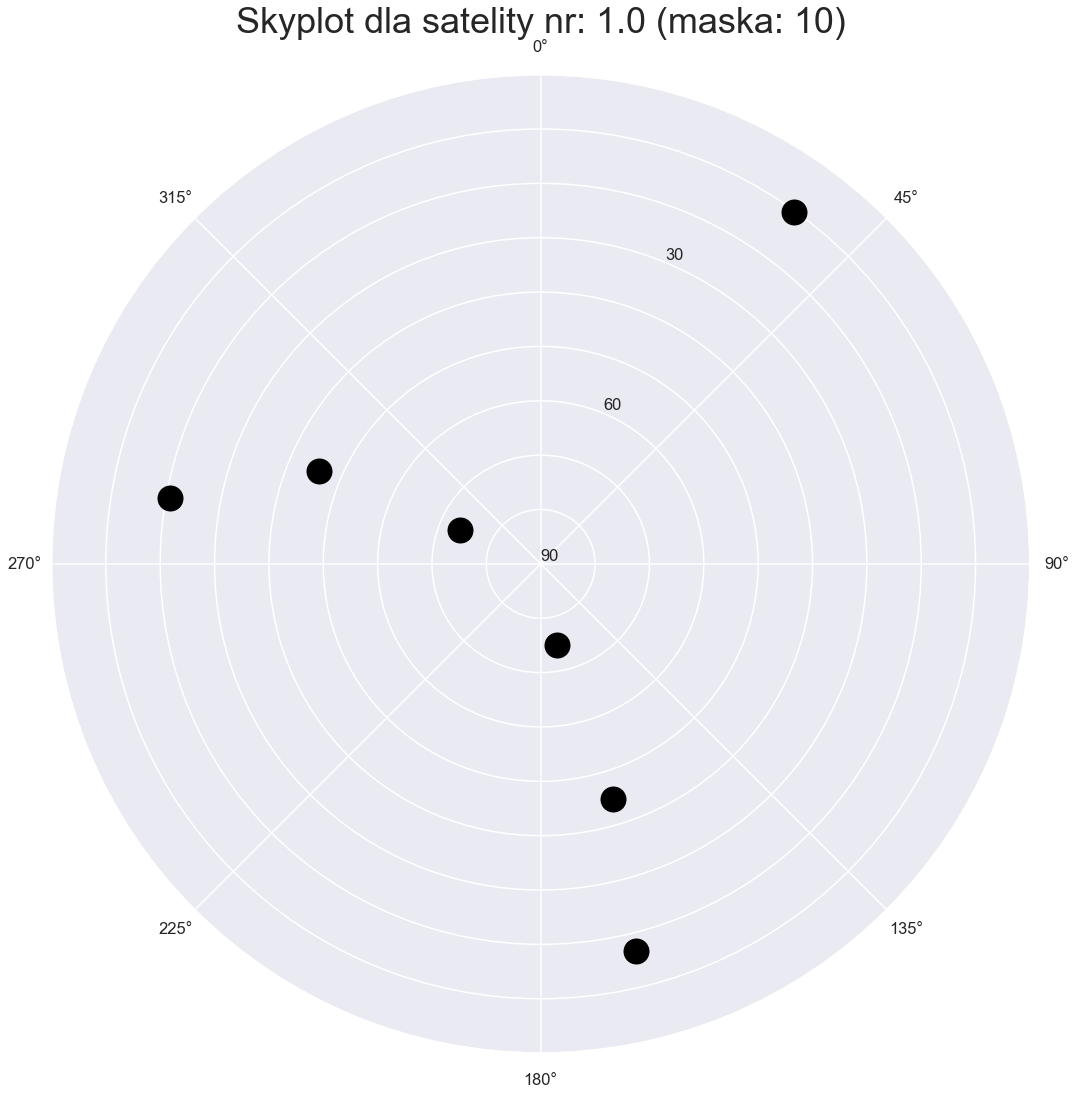

In [144]:
fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(polar=True)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

for el, az in better_elaz[NUMER]:
    ax.scatter(np.deg2rad(az), 90 - el, color='black', marker='o',s=600)

ax.set_yticks(range(0, 90+10, 10))
yLabel = ['90', '', '', '60', '', '', '30', '', '', '']
ax.set_yticklabels(yLabel)
ax.set_title('Skyplot dla satelity nr: ' + str(NUMER) + ' (maska: '+str(MASKA)+')', loc='center', fontsize=36)
plt.show()

###  ⚙️ wybór odstępu godzinowego od wybranej wcześniej daty

In [145]:
GODZINA = 0  # integer, 0 - 23, odstęp godzinowy od wybranej daty, dla którego będzie rysowany skyplot widocznych satelit

In [146]:
elaz_dict = dict()
idx = 0
for h, i in enumerate(ile_widocznych):
    for lista in satelity_elaz[idx:idx+i]:
        try:
            elaz_dict[h].extend([lista])
        except KeyError:
            elaz_dict[h] = [lista]
    idx += i

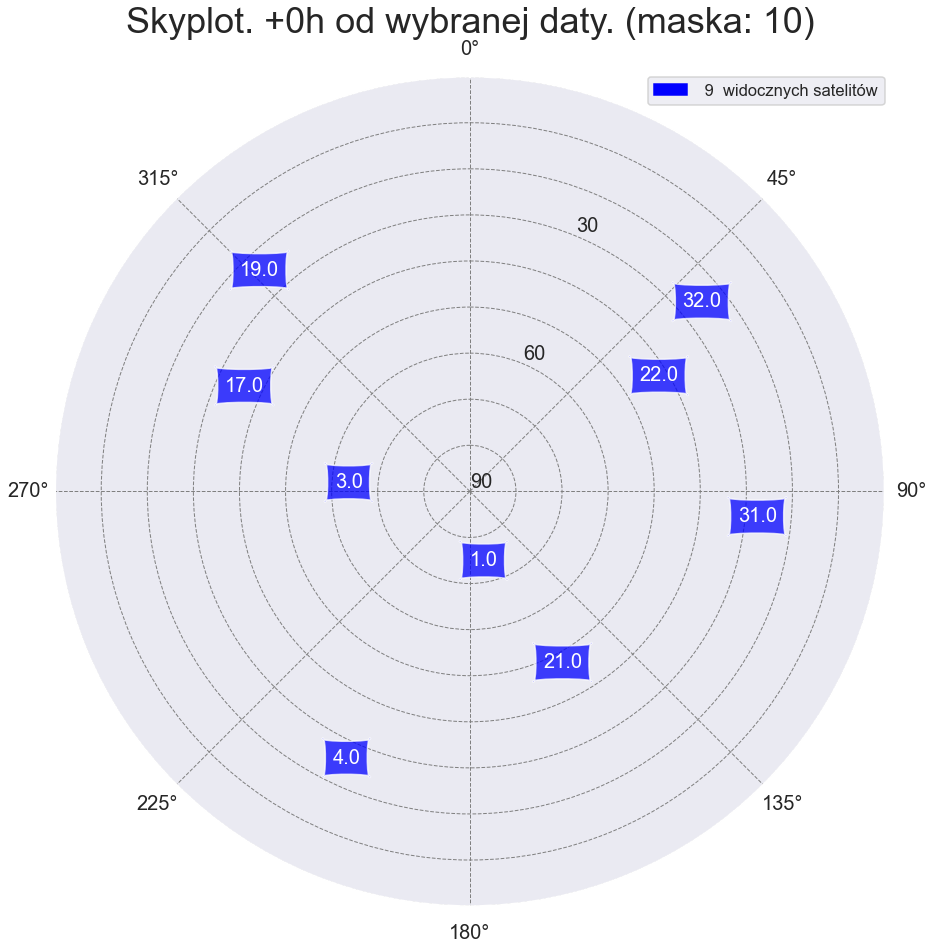

In [147]:
plot_skyplot(elaz_dict[GODZINA])

## Groundtrack

In [148]:
nume=[]
xxx=[]
yyy=[]
zzz=[]
hhh=[]
for k, v in satelity_xyz2.items():
    for i in range(len(v)):
        nume.append(k)
        hhh.append(i)
    for lista in v:
        xxx.append(lista[0])
        yyy.append(lista[1])
        zzz.append(lista[2])

In [149]:
filamdf = pd.DataFrame(list(zip(nume, xxx, yyy, zzz, hhh)), columns=['PRN', 'x', 'y', 'z', 'h'])
filamdf['fi'] = filamdf.apply(lambda row: Hirvonen(row[1], row[2], row[3], a=6378137, e2=0.00669437999013)[0], axis=1)
filamdf['lam'] = filamdf.apply(lambda row: Hirvonen(row[1], row[2], row[3], a=6378137, e2=0.00669437999013)[1], axis=1)

In [150]:
fig = px.line_mapbox(filamdf, lat='fi', lon='lam', color='PRN', hover_data=['PRN', 'h','fi', 'lam',],)

# fig.update_layout(mapbox_style="carto-positron", mapbox_zoom=1, mapbox_center_lon=0,  # open-street-map
#     margin={"r":0,"t":0,"l":0,"b":0})

fig.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "United States Geological Survey",
            "source": [
                "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
            ]
        }
      ],
    margin={"r":0,"t":0,"l":0,"b":0},
    mapbox_zoom=1,)

fig.show()

In [151]:
fig = px.scatter_mapbox(filamdf, lat='fi', lon='lam', color='PRN', hover_data=['PRN', 'h','fi', 'lam',],)

# fig.update_layout(mapbox_style="carto-positron", mapbox_zoom=1, mapbox_center_lon=0,  # open-street-map
#     margin={"r":0,"t":0,"l":0,"b":0})

fig.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "United States Geological Survey",
            "source": [
                "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
            ]
        }
      ],
    margin={"r":0,"t":0,"l":0,"b":0},
    mapbox_zoom=1,)

fig.show()

In [152]:
fig = px.line_geo(filamdf, lat='fi', lon='lam',
                  color="PRN",
                  projection="orthographic",
                 hover_data=['PRN', 'h','fi', 'lam',],)
fig.update_geos(
#     resolution=50,
#     showcoastlines=True, coastlinecolor="RebeccaPurple",
    showland=True, landcolor="#95c73e",
    showocean=True, oceancolor="#c7f3ff",
)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [153]:
fig = px.line_geo(filamdf, lat='fi', lon='lam',
                  color="PRN",
                  projection="robinson",
                 hover_data=['PRN', 'h','fi', 'lam',],)
fig.update_geos(
#     showland=True, landcolor="#95c73e",
#     showocean=True, oceancolor="#c7f3ff",
)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Globalna widoczność satelity dla ustalonej daty i maski

### ⚙️ wybór satelity 

In [154]:
NUMERR = 19.0  # numer PRN satelity, dla którego będzie rysowany wykres widoczności powyżej ustalonej maski

In [155]:
siatka = 5  # DOCELOWO 5
fis = [x for x in range(-80,81,siatka)]
lams = [x for x in range(-180,180,siatka)]
result = np.transpose([np.tile(lams, len(fis)), np.repeat(fis, len(lams))])

widocznoscdf = pd.DataFrame(list(zip([a[0] for a in result], [a[1] for a in result])), columns=['lam', 'fi'])

week, tow = date2tow(DATA)
sat = [sat for sat in navall if sat[0] == NUMERR][0]
Xs = satpos(sat, week, tow)
def is_visible(fi, lam, h=100):
    Xr = geo2xyz(fi, lam, h)
    neu = xyz2neu(fi, lam, Xr, Xs)
    n, e, u = neu
    ele = np.arcsin(u/np.sqrt(n**2 + e**2 + u**2))  # elewacja
    elst = np.rad2deg(ele)
    if elst >= MASKA:
        return 1
    else:
        return 0
    
widocznoscdf['visible'] = widocznoscdf.apply(lambda row: is_visible(row[1], row[0]), axis = 1)
# widocznoscdf


In [156]:
fig = px.scatter_geo(widocznoscdf, lat='fi', lon='lam',
                    projection="robinson",  # robinson orthographic
                    color='visible',
                    title='Globalna widoczność satelity PRN:'+str(NUMERR)+' '+str(date(*DATA[0:3]))+' '+str(time(*DATA[3:]))+' Maska: '+str(MASKA))  #hover_data=['PRN', 'h','fi', 'lam',], color="PRN",

# .query('visible==1')

fig.update_traces(marker=dict(symbol='square', size=24, opacity=0.1,
                              line=dict(width=0, color='DarkSlateGrey')))
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()

In [157]:
fig = px.scatter_geo(widocznoscdf, lat='fi', lon='lam',
                    projection="natural earth",  # robinson orthographic
                    color='visible',
                    title='Globalna widoczność satelity PRN:'+str(NUMERR)+' '+str(date(*DATA[0:3]))+' '+str(time(*DATA[3:]))+' Maska: '+str(MASKA))  #hover_data=['PRN', 'h','fi', 'lam',], color="PRN",

fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()

In [158]:
fig = px.scatter_geo(widocznoscdf, lat='fi', lon='lam',
                    projection="orthographic",  # robinson orthographic
                    color='visible',
                    title='Globalna widoczność satelity PRN:'+str(NUMERR)+' '+str(date(*DATA[0:3]))+' '+str(time(*DATA[3:]))+' Maska: '+str(MASKA))  #hover_data=['PRN', 'h','fi', 'lam',], color="PRN",

fig.update_traces(marker=dict(symbol='diamond', size=20, opacity=0.1,
                              line=dict(width=0, color='DarkSlateGrey')))
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()